In [13]:
import CorrelationsModels as CM
import ExpectedShortfall as ES
import InteractivePlots as IP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [14]:
# Define dates
dates = pd.date_range(start="2023-01-01", periods=8, freq="D")

# Create a simple x_matrix (monetary positions)
data = {
    "Asset A": [1000, 1020, 980, 990, 1010, 1005, 995, 1002],
    "Asset B": [500, 520, 510, 530, 525, 535, 540, 538],
    "Asset C": [200, 210, 205, 215, 220, 225, 230, 235]
}
x_matrix = pd.DataFrame(data, index=dates)
print("Input x_matrix:")
print(x_matrix)


Input x_matrix:
            Asset A  Asset B  Asset C
2023-01-01     1000      500      200
2023-01-02     1020      520      210
2023-01-03      980      510      205
2023-01-04      990      530      215
2023-01-05     1010      525      220
2023-01-06     1005      535      225
2023-01-07      995      540      230
2023-01-08     1002      538      235


In [15]:
# Run RiskMetrics VaR
rm_results, rm_next = CM.var_riskmetrics_param(x_matrix, confidence_level=0.99)
print("\nRiskMetrics VaR (last 3 rows):")
print(rm_results.tail(3))
print("Next-day VaR (RiskMetrics):", round(rm_next, 2))

# Run VEC VaR
vec_results, vec_next = CM.var_vec_param(x_matrix, confidence_level=0.99)
print("\nVEC VaR (last 3 rows):")
print(vec_results.tail(3))
print("Next-day VaR (VEC):", round(vec_next, 2))



RiskMetrics VaR (last 3 rows):
            Portfolio Return  Portfolio Volatility        VaR  VaR Violation
2023-01-06          0.005852             36.025137  83.807000          False
2023-01-07          0.000146             34.966730  81.344777          False
2023-01-08          0.005727             34.205839  79.574681          False
Next-day VaR (RiskMetrics): 79.57

VEC VaR (last 3 rows):
            Portfolio Return  Portfolio Volatility        VaR  VaR Violation
2023-01-06          0.005852             36.013755  83.780522          False
2023-01-07          0.000146             35.522723  82.638210          False
2023-01-08          0.005727             35.192290  81.869508          False
Next-day VaR (VEC): 81.87


In [16]:
# Sample data (8 periods, 2 assets)
dates = pd.date_range(start="2023-01-01", periods=11, freq="D")
data = {
    "Asset A": [1000, 1020, 980, 990, 1010, 1005, 995, 1002, 999, 1080, 1230],
    "Asset B": [500, 520, 510, 530, 525, 535, 540, 538, 550, 560, 570],
}
x_matrix = pd.DataFrame(data, index=dates)

# Run Rolling MA VaR with window size 3
ma_results, ma_next = CM.var_movingaverage_param(x_matrix, confidence_level=0.99, window_size=3)
print("\nMoving Average VaR (last 3 rows):")
print(ma_results.tail(3))
print("Next-day VaR (Moving Average):", round(ma_next, 2))


Moving Average VaR (last 3 rows):
            Portfolio Return  Portfolio Volatility         VaR  VaR Violation
2023-01-09          0.005989              7.186884   16.719191          False
2023-01-10          0.059603             48.467521  112.752315          False
2023-01-11          0.100562             75.751139  176.223501          False
Next-day VaR (Moving Average): 201.07


### Testing the empirical versions (they should be somewhat similar)

In [17]:
# Run Rolling MA (empirical) VaR with window size 3
ma_results_new, ma_next_new = CM.var_movingaverage_empirical(x_matrix, confidence_level=0.99, window_size=3)
print("\nMoving Average VaR EMPIRICAL (last 3 rows):")
print(ma_results_new.tail(3))
print("Next-day VaR (Moving Average):", round(ma_next_new, 2))


Moving Average VaR EMPIRICAL (last 3 rows):
             Returns  Volatility  Innovations        VaR  VaR Violation
2023-01-09  0.005989    7.186884     0.000457   7.362339          False
2023-01-10  0.059603   48.467521     0.000124  52.567635          False
2023-01-11  0.100562   75.751139     0.000787  90.174856          False
Next-day VaR (Moving Average): 102.89


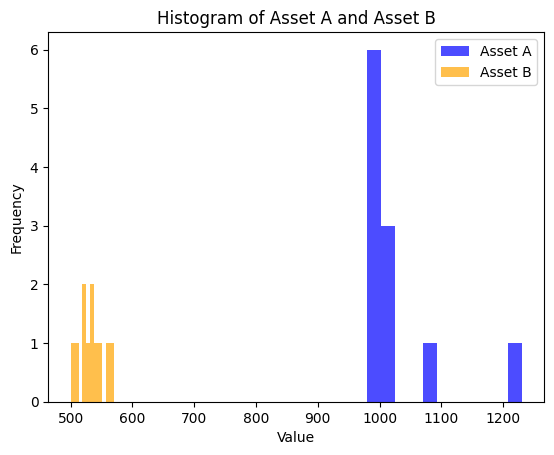

In [18]:
# Plot histogram for Asset A
x_matrix['Asset A'].plot.hist(bins=len(x_matrix['Asset A']), alpha=0.7, label='Asset A', color='blue')

# Plot histogram for Asset B
x_matrix['Asset B'].plot.hist(bins=len(x_matrix['Asset B']), alpha=0.7, label='Asset B', color='orange')

# Add labels and legend
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Asset A and Asset B')
plt.legend()
plt.show()

### Previous test was very stupid, lets try a better one

In [19]:
# Simulation settings
np.random.seed(42)
days = 500
assets = 2
dates = pd.date_range(start="2023-01-01", periods=days, freq="B")  # Business days

# Simulate daily returns: Normal with drift
mean_daily_return = 0.0005  # 0.05% per day
daily_volatility = 0.02  # 2% daily vol

returns = np.random.normal(loc=mean_daily_return, scale=daily_volatility, size=(days, assets))

# Simulate price paths
initial_prices = np.array([1000, 500])
price_paths = np.zeros((days, assets))
price_paths[0, :] = initial_prices

for t in range(1, days):
    price_paths[t, :] = price_paths[t-1, :] * (1 + returns[t, :])

# Put in DataFrame
x_matrix_simulated = pd.DataFrame(price_paths, index=dates, columns=["Asset A", "Asset B"])

print(x_matrix_simulated.head())


                Asset A     Asset B
2023-01-02  1000.000000  500.000000
2023-01-03  1013.453771  515.480299
2023-01-04  1009.214425  513.324179
2023-01-05  1041.594320  521.459697
2023-01-06  1032.335080  527.378891


In [20]:
# Run MA VaR parametric
ma_results, ma_next = CM.var_movingaverage_param(x_matrix_simulated, confidence_level=0.99, window_size=20)

# Run MA VaR empirical
ma_results_new, ma_next_new = CM.var_movingaverage_empirical(x_matrix_simulated, confidence_level=0.99, window_size=20)

print("\nParametric VaR (last 5 rows):")
print(ma_results.tail(5))

print("\nEmpirical VaR (last 5 rows):")
print(ma_results_new.tail(5))

print("\nNext-day VaR parametric:", round(ma_next, 2))
print("Next-day VaR empirical:", round(ma_next_new, 2))



Parametric VaR (last 5 rows):
            Portfolio Return  Portfolio Volatility        VaR  VaR Violation
2024-11-25         -0.013643             27.788526  64.645778          False
2024-11-26         -0.007963             27.402936  63.748761          False
2024-11-27         -0.013649             27.501837  63.978840          False
2024-11-28          0.027133             29.656316  68.990908          False
2024-11-29         -0.001582             29.939718  69.650200          False

Empirical VaR (last 5 rows):
             Returns  Volatility  Innovations        VaR  VaR Violation
2024-11-25 -0.013643   27.788526    -0.000066  77.971494          False
2024-11-26 -0.007963   27.402936    -0.000498  76.275846          False
2024-11-27 -0.013649   27.501837    -0.000290  75.502426          False
2024-11-28  0.027133   29.656316    -0.000460  83.616093          False
2024-11-29 -0.001582   29.939718     0.000906  84.270939          False

Next-day VaR parametric: 69.68
Next-day VaR 

behavior seems correct...

### Test RiskMetrics VaR

In [21]:
# Run MA VaR parametric
riskmetrics_results, riskmetrics_next = CM.var_riskmetrics_param(x_matrix_simulated, confidence_level=0.99)

# Run MA VaR empirical
riskmetrics_results_new, riskmetrics_next_new = CM.var_riskmetrics_empirical(x_matrix_simulated, confidence_level=0.99)

print("\nParametric VaR (last 5 rows):")
print(riskmetrics_results.tail(5))

print("\nEmpirical VaR (last 5 rows):")
print(riskmetrics_results_new.tail(5))

print("\nNext-day VaR parametric:", round(riskmetrics_next, 2))
print("Next-day VaR empirical:", round(riskmetrics_next_new, 2))



Parametric VaR (last 5 rows):
            Portfolio Return  Portfolio Volatility        VaR  VaR Violation
2024-11-25         -0.013643             27.336994  63.595357          False
2024-11-26         -0.007963             26.562892  61.794527          False
2024-11-27         -0.013649             26.279859  61.136095          False
2024-11-28          0.027133             29.411404  68.421157          False
2024-11-29         -0.001582             28.483546  66.262638          False

Empirical VaR (last 5 rows):
             Returns  Volatility  Innovations        VaR  VaR Violation
2024-11-25 -0.013643   27.336994    -0.000068  76.438861          False
2024-11-26 -0.007963   26.562892    -0.000514  73.681491          False
2024-11-27 -0.013649   26.279859    -0.000303  71.897759          False
2024-11-28  0.027133   29.411404    -0.000464  82.638330          False
2024-11-29 -0.001582   28.483546     0.000953  79.894575          False

Next-day VaR parametric: 66.26
Next-day VaR 

seems correct...

### VEC(1,1) test

In [22]:
# Run MA VaR parametric
vec_results, vec_next = CM.var_vec_param(x_matrix_simulated, confidence_level=0.99)

# Run MA VaR empirical
vec_results_new, vec_next_new = CM.var_vec_empirical(x_matrix_simulated, confidence_level=0.99)

print("\nParametric VaR (last 5 rows):")
print(vec_results.tail(5))

print("\nEmpirical VaR (last 5 rows):")
print(vec_results_new.tail(5))

print("\nNext-day VaR parametric:", round(vec_next, 2))
print("Next-day VaR empirical:", round(vec_next_new, 2))



Parametric VaR (last 5 rows):
            Portfolio Return  Portfolio Volatility        VaR  VaR Violation
2024-11-25         -0.013643             27.502076  63.979395          False
2024-11-26         -0.007963             27.293552  63.494296          False
2024-11-27         -0.013649             26.667636  62.038197          False
2024-11-28          0.027133             27.414174  63.774906          False
2024-11-29         -0.001582             28.588672  66.507197          False

Empirical VaR (last 5 rows):
             Returns  Volatility  Innovations        VaR  VaR Violation
2024-11-25 -0.013643   27.502076    -0.000496  79.977530          False
2024-11-26 -0.007963   27.293552    -0.000292  78.737599          False
2024-11-27 -0.013649   26.667636    -0.000512  75.878002          False
2024-11-28  0.027133   27.414174     0.000990  80.108760          False
2024-11-29 -0.001582   28.588672    -0.000055  83.398124          False

Next-day VaR parametric: 66.51
Next-day VaR 

### Plots and ES (PROBLEM)

In [23]:
import plotly.graph_objects as go

# Step 1: Compute empirical VaR
vec_results, vec_next_var = CM.var_riskmetrics_empirical(x_matrix_simulated, confidence_level=0.99)

# Step 2: Compute ES based on empirical innovations
vec_results = ES.compute_expected_shortfall_volatility(vec_results, confidence_level=0.99)

# Step 3: Plot VaR backtesting
fig_var = IP.interactive_plot_var(vec_results)
fig_var.show()

# Step 4: Plot ES backtesting
fig_es = IP.interactive_plot_es(vec_results)
fig_es.show()
